In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [10]:
end = dt.datetime.now()
start = '2011-09-13'
stocks = ['BTAL','TQQQ','IYE']
data = yf.download(stocks, start=start, end=end)

[*********************100%%**********************]  3 of 3 completed


In [11]:
data = data['Close']

In [12]:
returns = data.pct_change()
meanReturns = returns.mean()
covMatrix = returns.cov()

# weights = np.random.random(len(meanReturns))
# weights /= np.sum(weights)

weights = np.array([0.55, 0.37, 0.08])


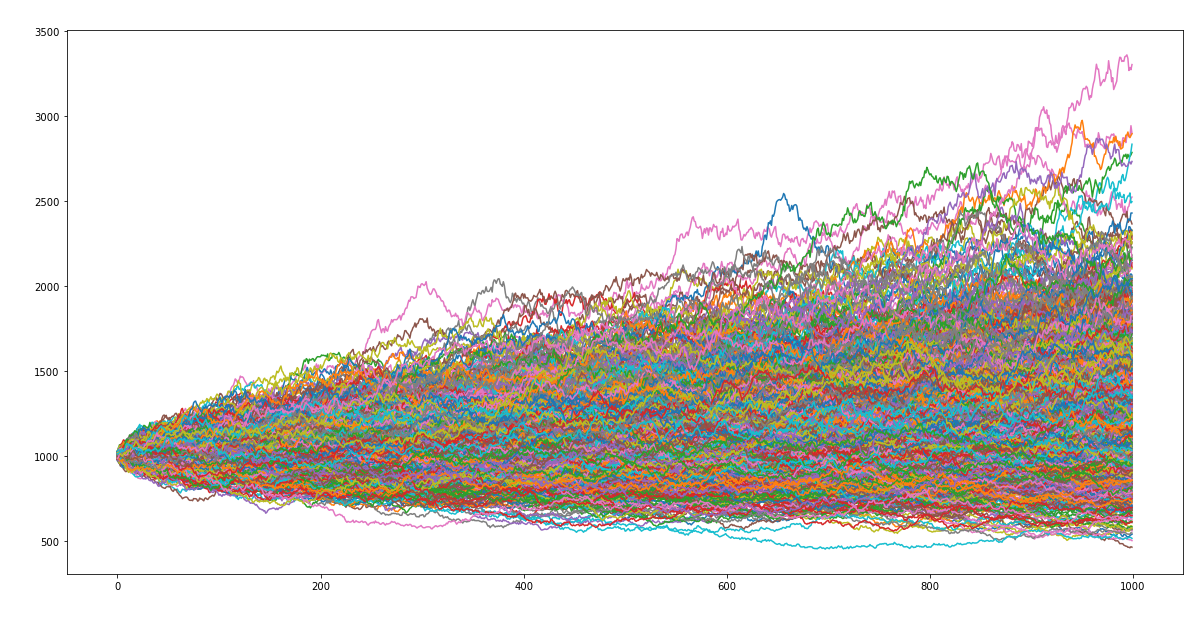

In [13]:
# Monte Carlo simulation
mc_sims = 1000 # number of simulations
T = 1000 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 1000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 25,
        }
plt.figure(figsize=(20, 10))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)',  fontdict=font)
plt.xlabel('Days',  fontdict=font)
plt.title('Monte carlo simulation of a stock portfolio',  fontdict=font)
plt.show()

In [14]:
def mcVaR(returns, alpha):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [15]:

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, 5)
CVaR = initialPortfolio - mcCVaR(portResults, 5)

print('VaR ${:,.2f}'.format(VaR,2))
print('CVaR ${:,.2f}'.format(CVaR,2))

VaR $256.27
CVaR $349.06


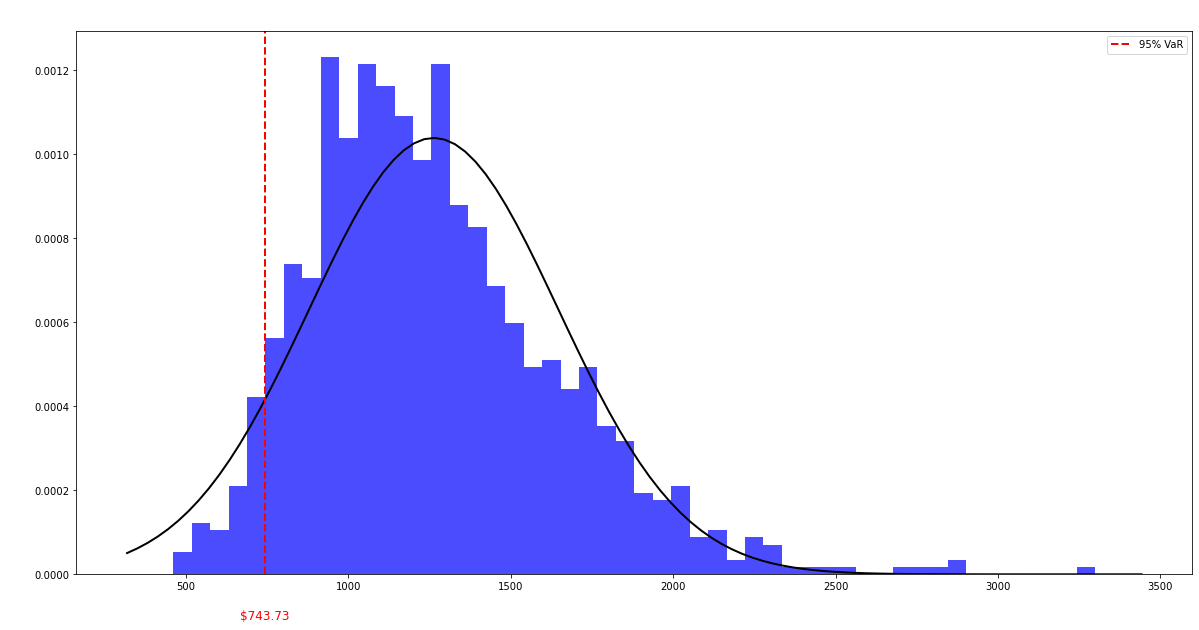

In [16]:
from scipy.stats import norm
final_portfolio_values = portfolio_sims[-1, :]


# Plot histogram and add bell curve
plt.figure(figsize=(20, 10))
plt.hist(final_portfolio_values, bins=50, density=True, alpha=0.7, color='blue')

# Add bell curve (normal distribution)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(final_portfolio_values), np.std(final_portfolio_values))
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.ylabel('Density', fontdict=font)
plt.xlabel('Portfolio Value ($)', fontdict=font)
plt.title('Monte Carlo Simulation - Portfolio Distribution', fontdict=font)

# Calculate and add 95% VaR
var_95 = np.percentile(final_portfolio_values, 5)
plt.axvline(var_95, color='red', linestyle='dashed', linewidth=2, label='95% VaR')
plt.legend()

plt.text(var_95, -0.0001, f'${var_95:.2f}', color='red', fontsize=12,
         horizontalalignment='center', verticalalignment='center')

plt.show()